# **Run Cellpose**

>**The model in Cellpose is trained on two-channel images.**
><br>&ensp; - **1st channel:** the channel you want to segment
><br>&ensp;&ensp;&ensp;&ensp; 0=grayscale, 1=red, 2=green, 3=blue
><br>&ensp; - **2nd channel:**  an optional channel that is helpful in models trained with images with a nucleus channel
><br>&ensp;&ensp;&ensp;&ensp;0=None (will set to zero), 1=red, 2=green, 3=blue

>**Therefore, we merged red & yellow channels together.**
><br>&ensp;
>|Channels|Cellular Compartments|Role|
>|-----:|:-----:|----|
>|**Red**|Microtubule|used as reference, cellular landmark|
>|**Blue** |Nuclei|"|
>|**Yellow**|Endoplasmic Reticulum (ER)|"|
>|**Green**|Protein of Interest|used to predict the label|

><br><br> **Save this code as a python file and run the command below:**
><br><br>&ensp; *python3 <u>path to your .py file</u> -i input_dir -o output_dir -g gpu_device -n n_trunk -b batch_size*

## **<u>1st Approach</u>**
> Run segmentation for each color channel separately

In [ ]:
# %%
from pathlib import Path
import argparse
from skimage.io import imread, imsave
from cellpose import models, plot, utils
from cellpose import io
import multiprocessing as mp
from tqdm import tqdm
import torch
import pandas as pd

# %%
def cellpose_seg(args):
    # Read the CSV file and extract the IDs
    csv_path = Path(args.i).joinpath('train.csv')
    df = pd.read_csv(csv_path)
    image_ids = df['ID'].tolist()

    # Construct filepaths for images with the suffix '_red_merged.png'
    filepaths = [Path(args.i).joinpath(f"{image_id}_red_merged.png") for image_id in image_ids]

    opdir = Path(args.o)
    opdir.mkdir(parents=True, exist_ok=True)
    n = args.n_trunk
    filepaths_split = [filepaths[i: i+n] for i in range(0, len(filepaths), n)] 

    model = models.Cellpose(gpu=True, model_type='cyto2', device=torch.device(f'cuda:{args.gpu_device}'))

    # Segmentation
    for filepaths in tqdm(filepaths_split):
        imgs = [imread(filepath) for filepath in filepaths]
        masks, flows, styles, diams = model.eval(imgs, 
                          diameter=150, 
                          channels=[3, 2],  # Adjust channels as needed
                          flow_threshold=0.8,
                          cellprob_threshold=0.0,
                          batch_size=args.batch_size, 
                        )
        opdatapath = [opdir.joinpath(f'{filepath.stem}.npy') for filepath in filepaths]
        opsegpath = [opdir.joinpath(f'{filepath.stem}.png') for filepath in filepaths]
        io.masks_flows_to_seg(imgs, masks, flows, diams, opdatapath)
        io.save_to_png(imgs, masks, flows, opsegpath)
    
    return

def main():
    description = "Cellpose segmentation script"
    parser = argparse.ArgumentParser(description=description)
    parser.add_argument('-i', type=str, required=True, help='input dir with image_list.csv')
    parser.add_argument('-o', type=str, required=True, help='output dir')
    parser.add_argument('-g', '--gpu_device', type=int, default=0, help='gpu device')    
    parser.add_argument('-n', '--n_trunk', type=int, default=10, help='number of trunk')
    parser.add_argument('-b', '--batch_size', type=int, default=256, help='batch size')
    args = parser.parse_args()
    cellpose_seg(args) 
    return    

if __name__ == "__main__":
    main()

# **Check Results**

> <u>**Output Formats**</u>
> <br>&ensp; **1: &ensp; _seg.npy**
> <br>&ensp;&ensp;&ensp; *dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])*
> <br>&ensp; **2: &ensp; _cp_masks.png**
> <br>&ensp; **3: &ensp; _cp_outlines.txt**

### Plot Mask Outlines for Each Color Channel

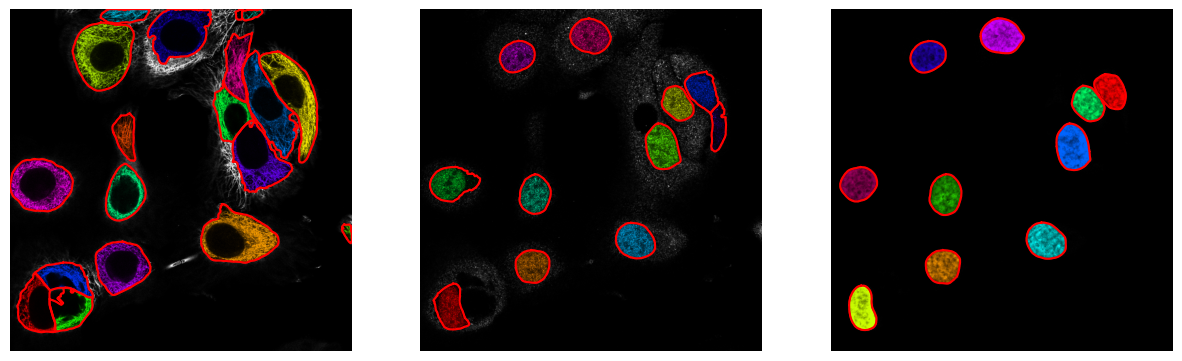

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot, utils
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/toy_dataset')

# File paths for the three .npy files for each color channel
file_names = [
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_red_merged_seg.npy',
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_green_seg.npy',  
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_blue_seg.npy'      
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data
    dat = np.load(file_path, allow_pickle=True).item()

    # Create mask overlay
    mask_RGB = plot.mask_overlay(dat['img'], dat['masks'])

    # Plot the image with masks overlaid
    axs[i].imshow(mask_RGB)
    axs[i].axis('off')  # Hide the axis

    # Plot outlines overlaid in red
    outlines = utils.outlines_list(dat['masks'])
    for o in outlines:
        axs[i].plot(o[:, 0], o[:, 1], color='r')

# Show the plot
plt.show()


### Overly Mask Outlines in One Image

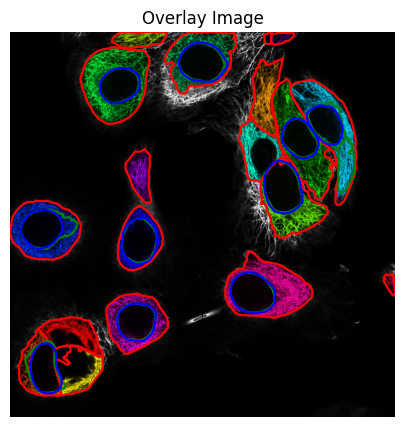

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot, utils
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/toy_dataset')

# File paths for the three .npy files for each color channel
file_names = [
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_red_merged_seg.npy',
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_green_seg.npy',  
    '3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_blue_seg.npy'      
]
file_paths = [base_dir / file_name for file_name in file_names]

# Colors for each file
outline_colors = ['red', 'green', 'blue']

# Load the base image (e.g., red_merged)
base_image_data = np.load(file_paths[0], allow_pickle=True).item()
base_image = base_image_data['img']

# Create a figure
plt.figure(figsize=(5, 5))

# Create mask overlay for the base image
mask_RGB = plot.mask_overlay(base_image, base_image_data['masks'])
plt.imshow(mask_RGB)
plt.title('Overlay Image')
plt.axis('off')

# Overlay outlines from all three images
for i, file_path in enumerate(file_paths):
    # Load the data for each image
    dat = np.load(file_path, allow_pickle=True).item()

    # Get the outlines
    outlines = utils.outlines_list(dat['masks'])
    for o in outlines:
        plt.plot(o[:, 0], o[:, 1], color=outline_colors[i])

# Show the plot
plt.show()


# **Crop Individual Cells with the Segmented Masks**
>&ensp; 1. Utilize the ID column from 'train.csv' to load corresponding **.npy** files for each image channel.
><br>&ensp; 2. Combine the three channels to form a **single RGB image** prior to cropping.
><br>&ensp; 3. Employ the **red channel mask** to isolate and crop 10 individual cells.
><br>&ensp; 4. Implement a *min_size* threshold, excluding images smaller than this specified size.
><br>&ensp; 5. Apply **zero-padding** around the cropped areas to maintain rectangular image shapes.
><br>&ensp; 6. Store the cropped images in the 'cropped_cells' directory as **.png** files. Additionally, encode the binary masks used for cropping into ASCII text using OID challenge encoding, and save this data in a single .txt file per ImageID.

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd

def load_rgb_image(base_dir, filename_stem):
    # Load red, green, blue channels
    red_img = np.load(base_dir / f'{filename_stem}_red_merged_seg.npy', allow_pickle=True).item()['img']
    green_img = np.load(base_dir / f'{filename_stem}_green_seg.npy', allow_pickle=True).item()['img']
    blue_img = np.load(base_dir / f'{filename_stem}_blue_seg.npy', allow_pickle=True).item()['img']

    # Merge channels to create an RGB image
    rgb_image = np.stack([red_img, green_img, blue_img], axis=-1)
    return rgb_image
    

def find_valid_crops(image, masks, min_size=(100, 100), max_save=10):
    valid_crops = []
    file_number = 1
    unique_masks = np.unique(masks)
    for mask_id in unique_masks:
        if mask_id == 0:
            continue
        mask = masks == mask_id

        where = np.where(mask)
        y_min, y_max = np.min(where[0]), np.max(where[0])
        x_min, x_max = np.min(where[1]), np.max(where[1])


        # Check if the crop size is at least 100x100
        if (y_max - y_min + 1) < min_size[0] or (x_max - x_min + 1) < min_size[1]:
            continue


        cropped_cell = np.zeros((y_max - y_min + 1, x_max - x_min + 1, 3), dtype=np.uint8)  # RGB
        for c in range(3):  # Copy color channels
            cropped_cell[..., c] = image[y_min:y_max+1, x_min:x_max+1, c] * mask[y_min:y_max+1, x_min:x_max+1]

        valid_crops.append((cropped_cell, file_number))
        file_number += 1

        if len(valid_crops) >= max_save:
            break

    return valid_crops

def save_crops(valid_crops, save_dir, orig_filename):
    for cropped_image, file_number in valid_crops:
        save_path = save_dir / f'{orig_filename}_cell{file_number}.png'
        Image.fromarray(cropped_image).save(save_path)


# Set base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/toy_dataset')

# Read the IDs from the CSV file
csv_path = base_dir / 'train.csv'
df = pd.read_csv(csv_path)
image_ids = df['ID'].tolist()

# Output directory for cropped cells
save_dir = base_dir / 'cropped_cells'
save_dir.mkdir(parents=True, exist_ok=True)

max_save = 10

# Iterate over IDs from the CSV file
for image_id in image_ids:
    orig_filename = f'{image_id}'

    image = load_rgb_image(base_dir, orig_filename)

    npy_file = base_dir / f'{orig_filename}_red_merged_seg.npy'
    dat = np.load(npy_file, allow_pickle=True).item()
    masks = dat['masks']

    valid_crops = find_valid_crops(image, masks, max_save=max_save)

    if len(valid_crops) == max_save:
        save_crops(valid_crops, save_dir, orig_filename)
    else:
        print(f"Warning: Expected to save {max_save} cells, but found only {len(valid_crops)} valid cells for file {orig_filename}")

In [3]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import base64
from pycocotools import _mask as coco_mask
import zlib
import typing as t

# Function to encode binary mask (red channel) used to crop the cells into OID challenge encoding ascii text
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    if mask.dtype != np.bool_:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1).astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')


def load_rgb_image(base_dir, filename_stem):
    # Load red, green, blue channels
    red_img = np.load(base_dir / f'{filename_stem}_red_merged_seg.npy', allow_pickle=True).item()['img']
    green_img = np.load(base_dir / f'{filename_stem}_green_seg.npy', allow_pickle=True).item()['img']
    blue_img = np.load(base_dir / f'{filename_stem}_blue_seg.npy', allow_pickle=True).item()['img']

    # Merge channels to create an RGB image
    rgb_image = np.stack([red_img, green_img, blue_img], axis=-1)
    return rgb_image
    

def find_valid_crops(image, masks, min_size=(100, 100), max_save=10):
    valid_crops = []
    file_number = 1
    mask_data = []  # Store encoded masks with file names
    unique_masks = np.unique(masks)
    for mask_id in unique_masks:
        if mask_id == 0:
            continue
        mask = masks == mask_id

        where = np.where(mask)
        y_min, y_max = np.min(where[0]), np.max(where[0])
        x_min, x_max = np.min(where[1]), np.max(where[1])


        # Check if the crop size is at least 100x100
        if (y_max - y_min + 1) < min_size[0] or (x_max - x_min + 1) < min_size[1]:
            continue

        # Encode mask and store with file number
        encoded_mask = encode_binary_mask(mask)
        mask_data.append((file_number, encoded_mask))

        cropped_cell = np.zeros((y_max - y_min + 1, x_max - x_min + 1, 3), dtype=np.uint8)  # RGB
        for c in range(3):  # Copy color channels
            cropped_cell[..., c] = image[y_min:y_max+1, x_min:x_max+1, c] * mask[y_min:y_max+1, x_min:x_max+1]

        valid_crops.append((cropped_cell, file_number))
        file_number += 1

        if len(valid_crops) >= max_save:
            break

    return valid_crops, mask_data

def save_crops_and_mask_data(valid_crops, mask_data, save_dir, orig_filename):
    for cropped_image, file_number in valid_crops:
        image_save_path = save_dir / f'{orig_filename}_cell{file_number}.png'
        Image.fromarray(cropped_image).save(image_save_path)

    mask_data_file = save_dir / f'{orig_filename}_masks.txt'
    with open(mask_data_file, 'w') as file:
        for file_number, encoded_mask in mask_data:
            file.write(f'{orig_filename}_cell{file_number}: {encoded_mask}\n')

# Set base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/5_train_240220')

# Read the IDs from the CSV file
csv_path = base_dir / '0_train_240220.csv'
df = pd.read_csv(csv_path)
image_ids = df['ID'].tolist()

# Output directory for cropped cells
save_dir = base_dir / 'cropped_cells2'
save_dir.mkdir(parents=True, exist_ok=True)

max_save = 10

# Iterate over IDs from the CSV file
for image_id in image_ids:
    orig_filename = f'{image_id}'

    image = load_rgb_image(base_dir, orig_filename)

    npy_file = base_dir / f'{orig_filename}_red_merged_seg.npy'
    dat = np.load(npy_file, allow_pickle=True).item()
    masks = dat['masks']

    valid_crops, mask_data = find_valid_crops(image, masks, max_save=max_save)

    if len(valid_crops) == max_save:
        save_crops_and_mask_data(valid_crops, mask_data, save_dir, orig_filename)
    else:
        print(f"Warning: Expected to save {max_save} cells, but found only {len(valid_crops)} valid cells for file {orig_filename}")


# **Check Results**

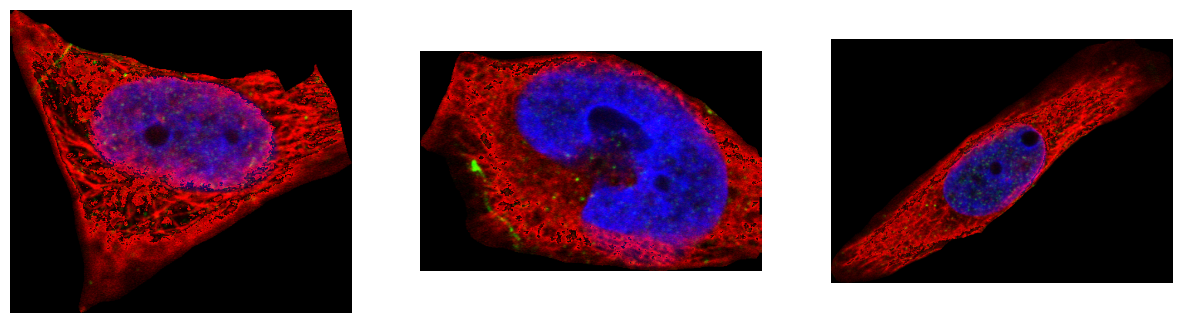

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/toy_dataset/cropped_cells_padding_RGB2/')

# File paths for the three .png files, relative to the base directory
file_names = [
    '2cb58486-bbae-11e8-b2ba-ac1f6b6435d0_cell3.png',
    '2cb58486-bbae-11e8-b2ba-ac1f6b6435d0_cell4.png',  
    '2cb58486-bbae-11e8-b2ba-ac1f6b6435d0_cell5.png'
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data (image)
    img = mpimg.imread(file_path)

    # Plot the image
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide the axis

# Show the plot
plt.show()


## **<u>2nd Approach</u>**
> Merge all color channels prior to running the Cellpose.
> <br>Use the green color channel to segment.

In [ ]:
from pathlib import Path
import argparse
from skimage.io import imread, imsave
import numpy as np
from cellpose import models, io
import multiprocessing as mp
from tqdm import tqdm
import torch
import pandas as pd

def merge_channels(base_dir, image_id):
    # Construct filepaths for red, green, and blue images
    red_path = base_dir.joinpath(f"{image_id}_red_merged.png")
    green_path = base_dir.joinpath(f"{image_id}_green.png")
    blue_path = base_dir.joinpath(f"{image_id}_blue.png")

    # Read the images
    red_image = imread(red_path)
    green_image = imread(green_path)
    blue_image = imread(blue_path)

    # Stack the images to form an RGB image
    merged_image = np.stack([red_image, green_image, blue_image], axis=-1)
    return merged_image

def cellpose_seg(args):
    # Read the CSV file and extract the IDs
    csv_path = Path(args.i).joinpath('0_train_240220.csv')
    df = pd.read_csv(csv_path)
    image_ids = df['ID'].tolist()

    # Base directory
    base_dir = Path('/project/btec-design3/kaggle_dataset/toy_dataset')
    opdir = Path(args.o)
    opdir.mkdir(parents=True, exist_ok=True)

    model = models.Cellpose(gpu=True, model_type='cyto2', device=torch.device(f'cuda:{args.gpu_device}'))

    # Process images in batches
    for image_id in tqdm(image_ids):
        merged_image = merge_channels(base_dir, image_id)
        masks, flows, styles, diams = model.eval([merged_image], 
                                                 diameter=150, 
                                                 channels=[2, 3], 
                                                 flow_threshold=0.8,
                                                 cellprob_threshold=0.0,
                                                 batch_size=args.batch_size)
        
        opdatapath = opdir.joinpath(f'{image_id}.npy')
        opsegpath = opdir.joinpath(f'{image_id}.png')
        io.masks_flows_to_seg([merged_image], masks, flows, diams, [opdatapath])
        io.save_to_png([merged_image], masks, flows, [opsegpath])
    
    return

def main():
    description = "Cellpose segmentation script with channel merging"
    parser = argparse.ArgumentParser(description=description)
    parser.add_argument('-i', type=str, required=True, help='input dir with image_list.csv')
    parser.add_argument('-o', type=str, required=True, help='output dir')
    parser.add_argument('-g', '--gpu_device', type=int, default=0, help='gpu device')    
    parser.add_argument('-b', '--batch_size', type=int, default=256, help='batch size')
    args = parser.parse_args()
    cellpose_seg(args) 
    return    

if __name__ == "__main__":
    main()


# **Check Results**

> <u>**Output Formats**</u>
> <br>&ensp; **1: &ensp; _seg.npy**
> <br>&ensp;&ensp;&ensp; *dict_keys(['img', 'outlines', 'masks', 'chan_choose', 'ismanual', 'filename', 'flows', 'est_diam'])*
> <br>&ensp; **2: &ensp; _cp_masks.png**
> <br>&ensp; **3: &ensp; _cp_output.png** 
> <br>&ensp; **4: &ensp; _cp_outlines.txt**


### Plot Mask Outlines for 3 Different Images

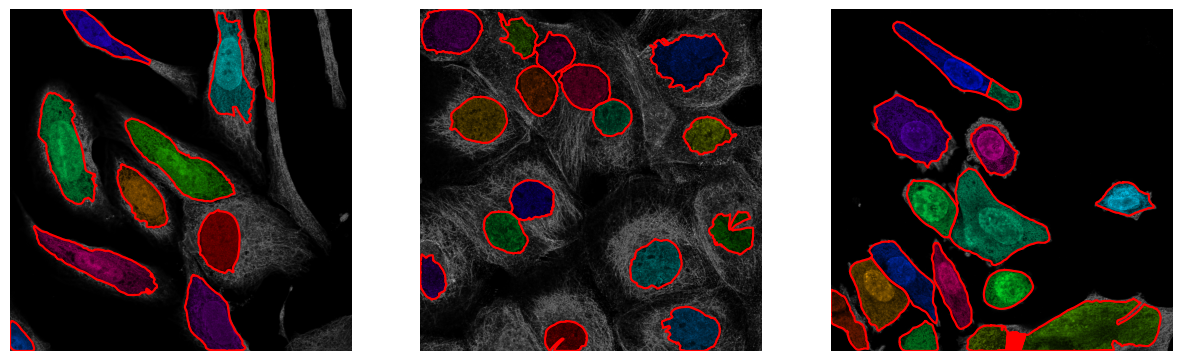

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot, utils
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/6_train_240220_RGB')

# File paths for the three .npy files for each color channel
file_names = [
    '4d240bd8-bb9b-11e8-b2b9-ac1f6b6435d0_seg.npy',
    '19b35894-bba0-11e8-b2b9-ac1f6b6435d0_seg.npy',  
    '48de5494-bbb3-11e8-b2ba-ac1f6b6435d0_seg.npy'      
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data
    dat = np.load(file_path, allow_pickle=True).item()

    # Create mask overlay
    mask_RGB = plot.mask_overlay(dat['img'], dat['masks'])

    # Plot the image with masks overlaid
    axs[i].imshow(mask_RGB)
    axs[i].axis('off')  # Hide the axis

    # Plot outlines overlaid in red
    outlines = utils.outlines_list(dat['masks'])
    for o in outlines:
        axs[i].plot(o[:, 0], o[:, 1], color='r')

# Show the plot
plt.show()


### Plot Green Channel Mask Outlines Generated by the 1st Approach

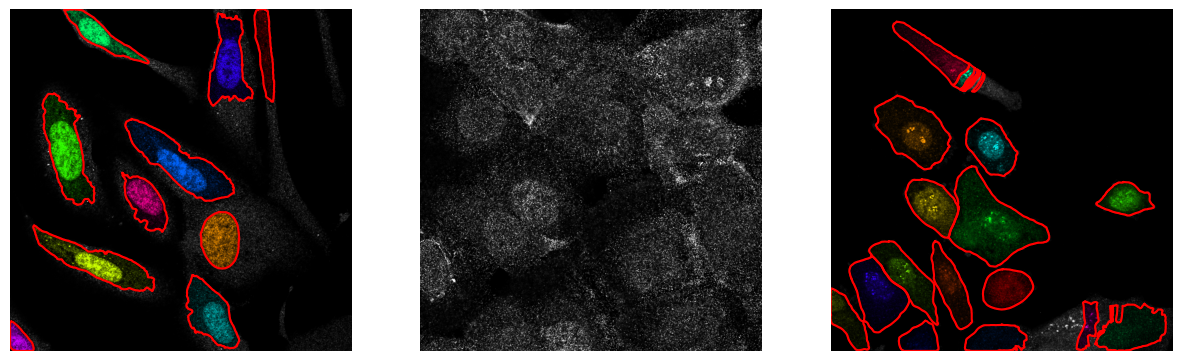

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot, utils
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/5_train_240220')

# File paths for the three .npy files for each color channel
file_names = [
    '4d240bd8-bb9b-11e8-b2b9-ac1f6b6435d0_green_seg.npy',
    '19b35894-bba0-11e8-b2b9-ac1f6b6435d0_green_seg.npy',  
    '48de5494-bbb3-11e8-b2ba-ac1f6b6435d0_green_seg.npy'      
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data
    dat = np.load(file_path, allow_pickle=True).item()

    # Create mask overlay
    mask_RGB = plot.mask_overlay(dat['img'], dat['masks'])

    # Plot the image with masks overlaid
    axs[i].imshow(mask_RGB)
    axs[i].axis('off')  # Hide the axis

    # Plot outlines overlaid in red
    outlines = utils.outlines_list(dat['masks'])
    for o in outlines:
        axs[i].plot(o[:, 0], o[:, 1], color='r')

# Show the plot
plt.show()


# **Crop Individual Cells with the Segmented Masks**
>&ensp; 1. Utilize the ID column from 'train.csv' to load corresponding **.npy** files for each image.
><br>&ensp; 2. Employ the **segmented mask** to isolate and crop 10 individual cells.
><br>&ensp; 4. Implement a *min_size* threshold, excluding images smaller than this specified size.
><br>&ensp; 5. Apply **zero-padding** around the cropped areas to maintain rectangular image shapes.
><br>&ensp; 6. Store the cropped images in the 'cropped_cells' directory as **.png** files. Additionally, encode the binary masks used for cropping into ASCII ><br>&ensp;&ensp;   text using OID challenge encoding, and save this data in a single .txt file per ImageID.

In [4]:
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import base64
from pycocotools import _mask as coco_mask
import zlib
import typing as t

# Function to encode binary mask (red channel) used to crop the cells into OID challenge encoding ascii text
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    if mask.dtype != np.bool_:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)

    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1).astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')


def find_valid_crops(image, masks, min_size=(100, 100), max_save=10):
    valid_crops = []
    file_number = 1
    mask_data = []  # Store encoded masks with file names
    unique_masks = np.unique(masks)
    for mask_id in unique_masks:
        if mask_id == 0:
            continue
        mask = masks == mask_id

        where = np.where(mask)
        y_min, y_max = np.min(where[0]), np.max(where[0])
        x_min, x_max = np.min(where[1]), np.max(where[1])


        # Check if the crop size is at least 100x100
        if (y_max - y_min + 1) < min_size[0] or (x_max - x_min + 1) < min_size[1]:
            continue

        # Encode mask and store with file number
        encoded_mask = encode_binary_mask(mask)
        mask_data.append((file_number, encoded_mask))

        cropped_cell = np.zeros((y_max - y_min + 1, x_max - x_min + 1, 3), dtype=np.uint8)  # RGB
        for c in range(3):  # Copy color channels
            cropped_cell[..., c] = image[y_min:y_max+1, x_min:x_max+1, c] * mask[y_min:y_max+1, x_min:x_max+1]

        valid_crops.append((cropped_cell, file_number))
        file_number += 1

        if len(valid_crops) >= max_save:
            break

    return valid_crops, mask_data

def save_crops_and_mask_data(valid_crops, mask_data, save_dir, orig_filename):
    for cropped_image, file_number in valid_crops:
        image_save_path = save_dir / f'{orig_filename}_cell{file_number}.png'
        Image.fromarray(cropped_image).save(image_save_path)

    mask_data_file = save_dir / f'{orig_filename}_masks.txt'
    with open(mask_data_file, 'w') as file:
        for file_number, encoded_mask in mask_data:
            file.write(f'{orig_filename}_cell{file_number}: {encoded_mask}\n')

# Set base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/6_train_240220_RGB')

# Read the IDs from the CSV file
csv_path = base_dir / '0_train_240220.csv'
df = pd.read_csv(csv_path)
image_ids = df['ID'].tolist()

# Output directory for cropped cells
save_dir = base_dir / 'cropped_cells'
save_dir.mkdir(parents=True, exist_ok=True)

max_save = 10

# Iterate over IDs from the CSV file
for image_id in image_ids:
    orig_filename = f'{image_id}'

    # Load RGB image and masks from a .npy file
    npy_file = base_dir / f'{orig_filename}_seg.npy'
    data = np.load(npy_file, allow_pickle=True).item()
    image = data['img']
    masks = data['masks']

    valid_crops, mask_data = find_valid_crops(image, masks, max_save=max_save)

    if len(valid_crops) == max_save:
        save_crops_and_mask_data(valid_crops, mask_data, save_dir, orig_filename)
    else:
        print(f"Warning: Expected to save {max_save} cells, but found only {len(valid_crops)} valid cells for file {orig_filename}")

# **Check Results**

### <u>1st Approach</u>

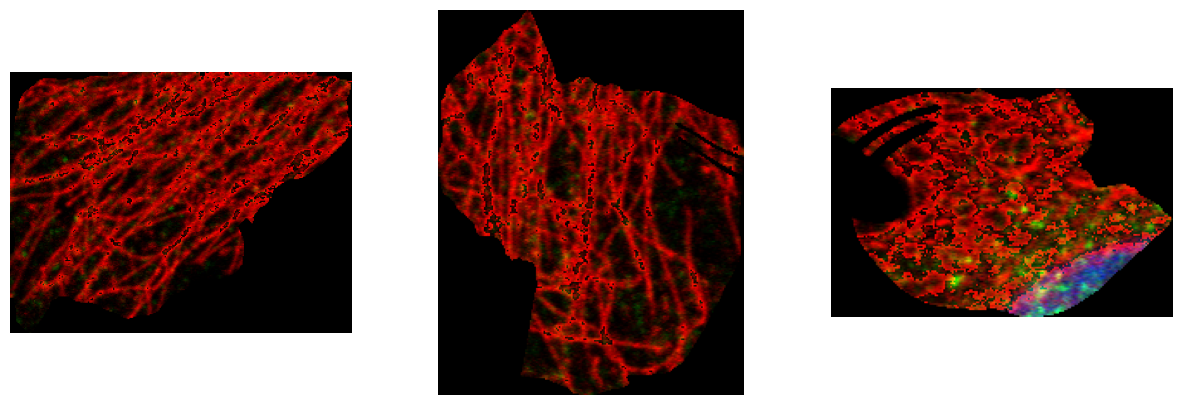

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/5_train_240220/cropped_cells')

# File paths for the three .png files, relative to the base directory
file_names = [
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell1.png',
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell2.png',  
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell3.png'
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data (image)
    img = mpimg.imread(file_path)

    # Plot the image
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide the axis

# Show the plot
plt.show()


### <u>2nd Approach</u>

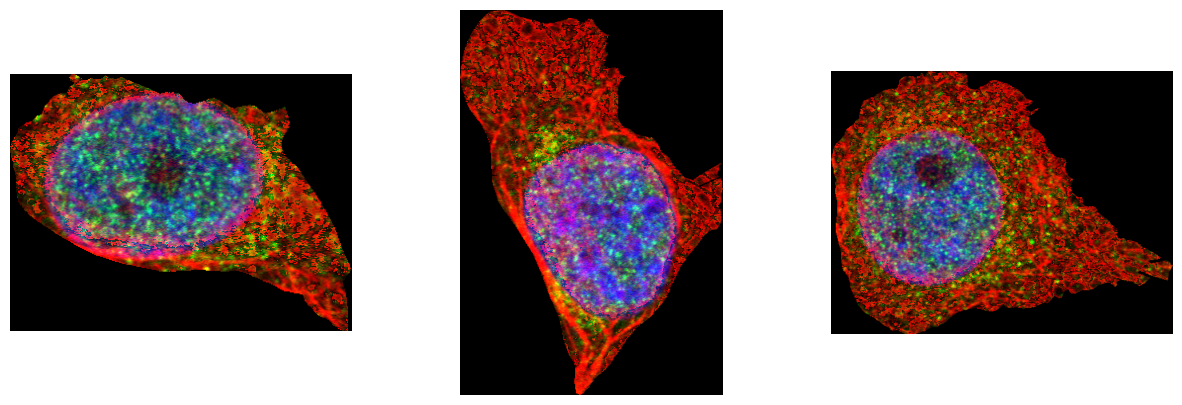

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Base directory
base_dir = Path('/projectnb/btec-design3/novanetworks/kaggle_HPA/2021/data/kaggle-dataset/CAM_images/images/cellpose_segmented/6_train_240220_RGB/cropped_cells')

# File paths for the three .png files, relative to the base directory
file_names = [
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell1.png',
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell2.png',  
    '918a9f7c-bbb3-11e8-b2ba-ac1f6b6435d0_cell3.png'
]
file_paths = [base_dir / file_name for file_name in file_names]

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each file and subplot
for i, file_path in enumerate(file_paths):
    # Load the data (image)
    img = mpimg.imread(file_path)

    # Plot the image
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide the axis

# Show the plot
plt.show()
